# Fine Tuning Experiments

## Dependencies Set-up

In [6]:
# --- Import Required Libraries ---
import os
import sys
import pandas as pd

# --- Set Up Paths ---
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
if ROOT_PATH not in sys.path:
    sys.path.insert(0, ROOT_PATH)

# --- Import Custom Libraries ---
from pop.util.print_results import (
    print_statistics,
    plot_fitness_diversity,
    compare_best_fitness_diversity,
    plot_time_per_run,
    plot_fitness_distribution,
    plot_fitness_vs_time
)
from pop.util.fine_tuning import (
    select_configs,
    get_results_path,
    generate_base_filename,
    fine_tune_algorithms_parallel, 
    run_selected_configs_parallel
)

## Parameter Definition

In [7]:
# Number of runs for statistically significant results
num_runs = 5

# Experiment parameters (define these explicitly)
dataset = "../dataset"
num_companies = 200
risk_free_rate = 0.042
start_date = "2015-01-01"
end_date = "2020-01-01"
correlation_level = None # 'low', 'medium', 'high', or None
seed = 0

## Hyperparameter Configuration

In [8]:
# Hyperparameters for Genetic Algorithm (GA)
ga_param_grid = {
    "pop_size": [200],
    "mutation_rate": [0.01, 0.05, 0.1],
    "gaussian_stdev": [0.01, 0.05, 0.1],
    "num_elites": [1, 2, 5],
    "max_generations": [50, 100]
}

# Hyperparameters for Particle Swarm Optimization (PSO)
pso_param_grid = {
    "swarm_size": [200],
    "max_iterations": [50, 100],
    "w": [0.4, 0.7, 0.9],
    "c1": [1.0, 1.5, 2.0],
    "c2": [1.0, 1.5, 2.0]
}

# Possible repair methods
REPAIR_METHODS = ["normalize", "shrink"]

## Fine-Tuning Run

- Experimentation with different hyperparameters

In [9]:
# Parallel fine-tuning for all configs
fine_tuning_results = fine_tune_algorithms_parallel(
    num_runs=5,
    dataset=dataset,
    num_companies=num_companies,
    risk_free_rate=risk_free_rate,
    start_date=start_date,
    end_date=end_date,
    correlation_level=correlation_level,
    seed=seed,
    ga_param_grid=ga_param_grid,
    pso_param_grid=pso_param_grid,
    REPAIR_METHODS=REPAIR_METHODS
)

Fine-tuning configs:   0%|          | 0/216 [00:00<?, ?it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.992533577). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run1_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run1_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run1_diversity.csv
✅ Run 1/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.01, 'num_elites': 1, 'max_generations': 50}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match num

Fine-tuning configs:   0%|          | 1/216 [00:11<41:12, 11.50s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999503085). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.05, 'num_elites': 1, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.999503085). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-P

Fine-tuning configs:   2%|▏         | 4/216 [00:11<07:15,  2.06s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.99188279). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.01, 'num_elites': 5, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.99188279). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Pro

Fine-tuning configs:   2%|▏         | 5/216 [00:11<04:58,  1.41s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.998934711). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.05, 'num_elites': 2, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.998934711). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-P

Fine-tuning configs:   3%|▎         | 6/216 [00:22<14:44,  4.21s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.995087141). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.01, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.995087141). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimizati

Fine-tuning configs:   5%|▍         | 10/216 [00:22<04:25,  1.29s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.994496261). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.01, 'num_elites': 5, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.994496261). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimizati

Fine-tuning configs:   6%|▌         | 12/216 [00:22<03:04,  1.10it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999901249). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.05, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.999901249). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimizati

Fine-tuning configs:   7%|▋         | 16/216 [00:33<05:14,  1.57s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.1, 'num_elites': 5, 'max_generations': 50}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Docu

Fine-tuning configs:   8%|▊         | 18/216 [00:33<03:55,  1.19s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.01, 'num_elites': 1, 'max_generations': 50}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Doc

Fine-tuning configs:   9%|▉         | 19/216 [00:34<03:30,  1.07s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.99479275). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.01, 'num_elites': 5, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.99479275). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Pro

Fine-tuning configs:   9%|▉         | 20/216 [00:43<09:04,  2.78s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.97931881). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.1, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.97931881). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-

Fine-tuning configs:  11%|█         | 23/216 [00:44<04:31,  1.41s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999491581). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.05, 'num_elites': 1, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.999491581). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-P

Fine-tuning configs:  11%|█         | 24/216 [00:44<03:47,  1.19s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.998101565). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.01, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.998101565). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimizati

Fine-tuning configs:  12%|█▏        | 25/216 [00:45<03:16,  1.03s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.995775731). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.05, 'num_elites': 2, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.995775731). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-P

Fine-tuning configs:  12%|█▏        | 26/216 [00:45<02:50,  1.11it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999542874). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.05, 'num_elites': 5, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.999542874). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-P

Fine-tuning configs:  13%|█▎        | 29/216 [00:55<05:53,  1.89s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.998309414). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.1, 'num_elites': 2, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.998309414). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Pr

Fine-tuning configs:  15%|█▍        | 32/216 [00:56<03:18,  1.08s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.993824653). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.05, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.993824653). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimizati

Fine-tuning configs:  15%|█▌        | 33/216 [01:06<09:05,  2.98s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999596524). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.05, 'num_elites': 5, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.999596524). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimizati

Fine-tuning configs:  16%|█▌        | 34/216 [01:06<07:20,  2.42s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999615057). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.1, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.999615057). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimizatio

Fine-tuning configs:  16%|█▌        | 35/216 [01:07<05:46,  1.92s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.980326571). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.01, 'num_elites': 2, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.980326571). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Probl

Fine-tuning configs:  17%|█▋        | 37/216 [01:07<03:16,  1.10s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999980989). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.1, 'num_elites': 1, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.999980989). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimizatio

Fine-tuning configs:  18%|█▊        | 39/216 [01:08<02:06,  1.40it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997359074). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.01, 'num_elites': 5, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.997359074). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Probl

Fine-tuning configs:  19%|█▊        | 40/216 [01:17<09:14,  3.15s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.937709718). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run4_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run4_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run4_diversity.csv
✅ Run 4/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 1, 'max_generations': 50}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number o

Fine-tuning configs:  19%|█▉        | 42/216 [01:18<05:18,  1.83s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999888878). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.05, 'num_elites': 2, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.999888878). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Probl

Fine-tuning configs:  20%|██        | 44/216 [01:19<02:48,  1.02it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.978595468). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.01, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.978595468). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-P

Fine-tuning configs:  21%|██        | 45/216 [01:19<02:46,  1.03it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997591336). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 1, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.997591336). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Proble

Fine-tuning configs:  21%|██▏       | 46/216 [01:20<02:24,  1.18it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.99843737). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.01, 'num_elites': 5, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.99843737). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Pro

Fine-tuning configs:  22%|██▏       | 47/216 [01:29<09:12,  3.27s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9930142098595179). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run4_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run4_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run4_diversity.csv
✅ Run 4/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.01, 'num_elites': 1, 'max_generations': 50}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not ma

Fine-tuning configs:  22%|██▏       | 48/216 [01:29<06:47,  2.42s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 2, 'max_generations': 50}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents

Fine-tuning configs:  23%|██▎       | 49/216 [01:30<05:14,  1.88s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999888878). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.05, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.999888878). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-P

Fine-tuning configs:  23%|██▎       | 50/216 [01:30<03:57,  1.43s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.998107908). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 5, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.998107908). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Proble

Fine-tuning configs:  24%|██▍       | 52/216 [01:31<02:33,  1.07it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9734383964389035). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.01, 'num_elites': 1, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9734383964389035). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  25%|██▍       | 53/216 [01:40<08:35,  3.16s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 1, 'max_generations': 100}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Docu

Fine-tuning configs:  25%|██▌       | 54/216 [01:41<06:45,  2.50s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9979678554887148). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.01, 'num_elites': 2, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9979678554887148). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  25%|██▌       | 55/216 [01:42<05:30,  2.05s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 2, 'max_generations': 100}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Docu

Fine-tuning configs:  27%|██▋       | 58/216 [01:43<02:57,  1.12s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9935923318212627). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.01, 'num_elites': 1, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.9935923318212627). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfo

Fine-tuning configs:  28%|██▊       | 60/216 [01:51<05:43,  2.20s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9994718545592814). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.05, 'num_elites': 2, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9994718545592814). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  28%|██▊       | 61/216 [01:53<05:08,  1.99s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9994710659026872). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.01, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.9994710659026872). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfo

Fine-tuning configs:  29%|██▊       | 62/216 [01:53<04:23,  1.71s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9912848126731577). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.05, 'num_elites': 5, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9912848126731577). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  30%|██▉       | 64/216 [01:54<02:50,  1.12s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9999168852045424). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.1, 'num_elites': 1, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9999168852045424). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-O

Fine-tuning configs:  30%|███       | 65/216 [01:55<02:25,  1.04it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9947391201266164). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.05, 'num_elites': 1, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.9947391201266164). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfo

Fine-tuning configs:  31%|███       | 66/216 [01:55<01:56,  1.29it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9974311490045761). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.1, 'num_elites': 2, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9974311490045761). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-O

Fine-tuning configs:  31%|███       | 67/216 [02:04<07:47,  3.14s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9872747597649514). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run4_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run4_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run4_diversity.csv
✅ Run 4/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.01, 'num_elites': 2, 'max_generations': 50}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not ma

Fine-tuning configs:  31%|███▏      | 68/216 [02:05<05:56,  2.41s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9996480693632125). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.1, 'num_elites': 5, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9996480693632125). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-O

Fine-tuning configs:  32%|███▏      | 69/216 [02:06<04:57,  2.03s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.994268952928193). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.05, 'num_elites': 5, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.994268952928193). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfoli

Fine-tuning configs:  33%|███▎      | 71/216 [02:06<02:47,  1.15s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9964435336866401). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.01, 'num_elites': 1, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9964435336866401). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  33%|███▎      | 72/216 [02:07<02:31,  1.05s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9972279439063338). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.1, 'num_elites': 1, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.9972279439063338). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfol

Fine-tuning configs:  34%|███▍      | 73/216 [02:15<07:22,  3.09s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9945304251944371). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.1, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.9945304251944371). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfol

Fine-tuning configs:  34%|███▍      | 74/216 [02:16<05:54,  2.50s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9958295595340613). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.01, 'num_elites': 5, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9958295595340613). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  35%|███▍      | 75/216 [02:17<04:49,  2.05s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9999513812881975). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.01_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.01, 'gaussian_stdev': 0.1, 'num_elites': 5, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.9999513812881975). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfol

Fine-tuning configs:  35%|███▌      | 76/216 [02:18<03:52,  1.66s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.998611123272423). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.05, 'num_elites': 1, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.998611123272423). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Op

Fine-tuning configs:  36%|███▌      | 77/216 [02:18<03:01,  1.31s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.01, 'num_elites': 1, 'max_generations': 100}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_aggregated_results.csv
✅ Fitness history saved to /Users/stefa

Fine-tuning configs:  36%|███▌      | 78/216 [02:19<02:24,  1.04s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.01, 'num_elites': 2, 'max_generations': 100}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_aggregated_results.csv
✅ Fitness history saved to /Users/stefa

Fine-tuning configs:  37%|███▋      | 79/216 [02:19<01:59,  1.15it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9975949642604918). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run3_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run3_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run3_diversity.csv
✅ Run 3/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.01, 'num_elites': 5, 'max_generations': 100}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does no

Fine-tuning configs:  37%|███▋      | 80/216 [02:27<06:49,  3.01s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9915529313524756). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.05, 'num_elites': 5, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9915529313524756). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  38%|███▊      | 81/216 [02:28<05:30,  2.45s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9991662619959465). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.01, 'num_elites': 5, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.9991662619959465). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfo

Fine-tuning configs:  38%|███▊      | 82/216 [02:30<04:33,  2.04s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9999600430634207). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.1, 'num_elites': 1, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9999600430634207). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-O

Fine-tuning configs:  38%|███▊      | 83/216 [02:30<03:40,  1.66s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9962692098031579). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.1, 'num_elites': 2, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9962692098031579). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-O

Fine-tuning configs:  39%|███▉      | 84/216 [02:31<02:58,  1.35s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run3_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run3_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run3_diversity.csv
✅ Run 3/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.05, 'num_elites': 5, 'max_generations': 100}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do n

Fine-tuning configs:  39%|███▉      | 85/216 [02:32<02:25,  1.11s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.998623681541548). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.1, 'num_elites': 5, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.998623681541548). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Opt

Fine-tuning configs:  40%|███▉      | 86/216 [02:32<02:05,  1.04it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9753184828987407). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.05, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.9753184828987407). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfo

Fine-tuning configs:  40%|████      | 87/216 [02:40<06:49,  3.17s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9986644161775763). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run4_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run4_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run4_diversity.csv
✅ Run 4/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.01, 'num_elites': 2, 'max_generations': 50}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match 

Fine-tuning configs:  41%|████      | 88/216 [02:41<05:03,  2.37s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9832690622580221). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run2_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run2_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run2_diversity.csv
✅ Run 2/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.01, 'num_elites': 2, 'max_generations': 100}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not ma

Fine-tuning configs:  41%|████      | 89/216 [02:42<04:14,  2.00s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9979931142824282). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.1, 'num_elites': 1, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.9979931142824282). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfol

Fine-tuning configs:  42%|████▏     | 90/216 [02:43<03:29,  1.66s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9961858309234717). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.01, 'num_elites': 2, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9961858309234717). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Opti

Fine-tuning configs:  42%|████▏     | 91/216 [02:43<02:39,  1.28s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9983621411853888). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run1_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run1_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run1_diversity.csv
✅ Run 1/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.05, 'num_elites': 1, 'max_generations': 50}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match 

Fine-tuning configs:  43%|████▎     | 92/216 [02:44<02:07,  1.03s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9927076316049315). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.01, 'num_elites': 5, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9927076316049315). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Opti

Fine-tuning configs:  43%|████▎     | 93/216 [02:52<06:24,  3.13s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9996710949430935). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.05_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.05, 'gaussian_stdev': 0.1, 'num_elites': 5, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.9996710949430935). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfol

Fine-tuning configs:  44%|████▎     | 94/216 [02:53<05:11,  2.55s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run2_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run2_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run2_diversity.csv
✅ Run 2/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.05, 'num_elites': 2, 'max_generations': 100}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not s

Fine-tuning configs:  44%|████▍     | 95/216 [02:54<04:17,  2.13s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.01, 'num_elites': 1, 'max_generations': 100}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Doc

Fine-tuning configs:  44%|████▍     | 96/216 [02:55<03:21,  1.68s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9831144796774366). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run1_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run1_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run1_diversity.csv
✅ Run 1/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 1, 'max_generations': 50}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match n

Fine-tuning configs:  45%|████▍     | 97/216 [02:56<02:58,  1.50s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.998123831560858). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.01, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.998123831560858). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Op

Fine-tuning configs:  46%|████▌     | 99/216 [02:57<01:57,  1.00s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.01, 'num_elites': 5, 'max_generations': 100}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Doc

Fine-tuning configs:  46%|████▋     | 100/216 [03:04<05:04,  2.63s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9993261520209538). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 1, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9993261520209538). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  47%|████▋     | 101/216 [03:06<04:45,  2.48s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9993003337218357). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.05, 'num_elites': 1, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.9993003337218357). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  47%|████▋     | 102/216 [03:08<04:04,  2.14s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9991395860503424). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 2, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9991395860503424). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  48%|████▊     | 103/216 [03:08<03:06,  1.65s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9959388561139726). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.05, 'num_elites': 2, 'max_generations': 100}
⚠️ Weights do not sum to 1 (total: 0.9959388561139726). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  48%|████▊     | 104/216 [03:08<02:25,  1.30s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.9851008583301083). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-50_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 5, 'max_generations': 50}
⚠️ Weights do not sum to 1 (total: 0.9851008583301083). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  49%|████▊     | 105/216 [03:09<02:03,  1.11s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run1_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run1_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run1_diversity.csv
✅ Run 1/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.0, 'c2': 1.5}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997843555287526

Fine-tuning configs:  49%|████▉     | 106/216 [03:18<06:05,  3.33s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.0, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  50%|████▉     | 107/216 [03:18<04:25,  2.44s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 1, 'max_generations': 100}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Docu

Fine-tuning configs:  50%|█████     | 108/216 [03:19<03:44,  2.08s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 2, 'max_generations': 100}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Docu

Fine-tuning configs:  50%|█████     | 109/216 [03:21<03:28,  1.95s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_run5_diversity.csv
✅ Run 5/5 completed for ga - {'pop_size': 200, 'mutation_rate': 0.1, 'gaussian_stdev': 0.1, 'num_elites': 5, 'max_generations': 100}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/exp_N_ps-200_mg-100_mr-0.1_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Docu

Fine-tuning configs:  51%|█████     | 110/216 [03:25<04:43,  2.68s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run1_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run1_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run1_diversity.csv
✅ Run 1/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 1.0, 'c2': 1.5}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.996720141). Nor

Fine-tuning configs:  51%|█████▏    | 111/216 [03:27<04:19,  2.47s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.0, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  52%|█████▏    | 112/216 [03:28<03:34,  2.06s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.5, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  52%|█████▏    | 113/216 [03:29<02:45,  1.61s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.5, 'c2': 1.5}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  53%|█████▎    | 115/216 [03:30<01:34,  1.07it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.5, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  54%|█████▎    | 116/216 [03:38<05:29,  3.29s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 2.0, 'c2': 1.5}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  54%|█████▍    | 117/216 [03:39<04:02,  2.44s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 2.0, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  55%|█████▍    | 118/216 [03:40<03:09,  1.93s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 1.0, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  55%|█████▌    | 119/216 [03:42<03:16,  2.02s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run3_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run3_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run3_diversity.csv
✅ Run 3/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 2.0, 'c2': 1.0}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.996720141). Nor

Fine-tuning configs:  56%|█████▌    | 120/216 [03:46<04:08,  2.58s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 1.0, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  56%|█████▌    | 121/216 [03:48<04:02,  2.55s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.996696074). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run2_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run2_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run2_diversity.csv
✅ Run 2/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 1.0, 'c2': 1.5}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncatin

Fine-tuning configs:  57%|█████▋    | 123/216 [03:49<02:24,  1.56s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 1.5, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  58%|█████▊    | 125/216 [03:50<01:34,  1.04s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 2.0, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  58%|█████▊    | 126/216 [03:59<04:46,  3.18s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 2.0, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  59%|█████▉    | 127/216 [03:59<03:30,  2.37s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 1.0, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  59%|█████▉    | 128/216 [04:00<02:52,  1.96s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 1.0, 'c2': 1.5}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  60%|█████▉    | 129/216 [04:02<03:03,  2.11s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run3_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run3_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run3_diversity.csv
✅ Run 3/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 2.0, 'c2': 2.0}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Nor

Fine-tuning configs:  60%|██████    | 130/216 [04:06<03:31,  2.46s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 1.5, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  61%|██████    | 131/216 [04:08<03:35,  2.53s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 1.5, 'c2': 1.5}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  61%|██████    | 132/216 [04:09<02:38,  1.89s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 1.5, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  62%|██████▏   | 133/216 [04:09<01:57,  1.41s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 2.0, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  62%|██████▏   | 134/216 [04:11<01:56,  1.43s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 2.0, 'c2': 1.5}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  62%|██████▎   | 135/216 [04:11<01:30,  1.12s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 2.0, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.999399979). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/ex

Fine-tuning configs:  63%|██████▎   | 136/216 [04:38<11:46,  8.83s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.0, 'c2': 1.5}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  63%|██████▎   | 137/216 [04:39<08:29,  6.45s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.0, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  64%|██████▍   | 138/216 [04:39<06:03,  4.66s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.0, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  64%|██████▍   | 139/216 [04:43<05:42,  4.45s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.5, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  65%|██████▍   | 140/216 [04:45<04:45,  3.76s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.5, 'c2': 1.5}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  65%|██████▌   | 141/216 [04:48<04:14,  3.39s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.5, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  66%|██████▌   | 142/216 [04:49<03:13,  2.61s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 2.0, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  66%|██████▌   | 143/216 [04:49<02:30,  2.06s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 2.0, 'c2': 1.5}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  67%|██████▋   | 144/216 [04:51<02:09,  1.80s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 1.0, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  67%|██████▋   | 145/216 [04:52<01:49,  1.54s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 2.0, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  68%|██████▊   | 146/216 [05:17<10:16,  8.81s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 1.0, 'c2': 1.5}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  69%|██████▊   | 148/216 [05:20<05:27,  4.82s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 1.5, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  69%|██████▉   | 149/216 [05:25<05:25,  4.86s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 1.5, 'c2': 1.5}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  69%|██████▉   | 150/216 [05:26<04:04,  3.70s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 1.5, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  70%|██████▉   | 151/216 [05:28<03:44,  3.45s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 2.0, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  70%|███████   | 152/216 [05:29<02:43,  2.56s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 2.0, 'c2': 1.5}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  71%|███████   | 153/216 [05:30<02:08,  2.04s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 2.0, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  71%|███████▏  | 154/216 [05:31<01:46,  1.72s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 1.0, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  72%|███████▏  | 155/216 [05:32<01:38,  1.61s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 1.0, 'c2': 1.5}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  72%|███████▏  | 156/216 [05:49<06:20,  6.33s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.0, 'c2': 1.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  73%|███████▎  | 157/216 [05:51<04:49,  4.91s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.0, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  73%|███████▎  | 158/216 [05:52<03:33,  3.68s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.0, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  74%|███████▎  | 159/216 [05:58<04:15,  4.49s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 1.0, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  74%|███████▍  | 160/216 [06:01<03:37,  3.89s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 1.5, 'c2': 1.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  75%|███████▍  | 161/216 [06:02<02:44,  2.99s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.985466926). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run4_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run4_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run4_diversity.csv
✅ Run 4/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 2.0, 'c2': 1.5}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Trunc

Fine-tuning configs:  75%|███████▌  | 162/216 [06:06<03:06,  3.46s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 1.5, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  75%|███████▌  | 163/216 [06:07<02:15,  2.56s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run4_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run4_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run4_diversity.csv
✅ Run 4/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.5, 'c2': 1.5}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Nor

Fine-tuning configs:  76%|███████▌  | 164/216 [06:09<02:13,  2.57s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.5, 'c2': 1.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  76%|███████▋  | 165/216 [06:10<01:39,  1.95s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run2_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run2_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run2_diversity.csv
✅ Run 2/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 2.0, 'c2': 2.0}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Nor

Fine-tuning configs:  77%|███████▋  | 166/216 [06:10<01:12,  1.45s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 2.0, 'c2': 2.0}
⚠️ Weights do not sum to 1 (total: 0.997164567). Normalizing.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ps

Fine-tuning configs:  77%|███████▋  | 167/216 [06:10<00:57,  1.17s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.5, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  78%|███████▊  | 168/216 [06:12<00:59,  1.23s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 1.5, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  78%|███████▊  | 169/216 [06:18<02:02,  2.60s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run2_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run2_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run2_diversity.csv
✅ Run 2/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 1.5, 'c2': 1.0}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/B

Fine-tuning configs:  79%|███████▊  | 170/216 [06:21<02:08,  2.80s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 2.0, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  79%|███████▉  | 171/216 [06:22<01:39,  2.21s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.4, 'c1': 2.0, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  80%|████████  | 173/216 [06:27<01:31,  2.13s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 1.0, 'c2': 1.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  81%|████████  | 174/216 [06:29<01:32,  2.20s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 1.0, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  81%|████████  | 175/216 [06:30<01:16,  1.88s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run3_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run3_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run3_diversity.csv
✅ Run 3/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 2.0, 'c2': 1.5}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/B

Fine-tuning configs:  81%|████████▏ | 176/216 [06:30<00:56,  1.40s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run2_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run2_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run2_diversity.csv
✅ Run 2/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 1.0, 'c2': 1.0}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/B

Fine-tuning configs:  82%|████████▏ | 177/216 [06:31<00:39,  1.02s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 1.5, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  82%|████████▏ | 178/216 [06:33<00:49,  1.31s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 2.0, 'c2': 1.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  83%|████████▎ | 179/216 [06:38<01:32,  2.51s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.7, 'c1': 2.0, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.7_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  83%|████████▎ | 180/216 [06:42<01:42,  2.84s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run3_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run3_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run3_diversity.csv
✅ Run 3/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 1.5, 'c2': 1.0}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/B

Fine-tuning configs:  84%|████████▍ | 181/216 [06:43<01:26,  2.46s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 1.0, 'c2': 1.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  84%|████████▍ | 182/216 [06:47<01:41,  2.98s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 1.0, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  85%|████████▌ | 184/216 [06:50<01:10,  2.19s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 1.5, 'c2': 1.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  86%|████████▌ | 185/216 [06:51<01:00,  1.96s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 1.5, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  87%|████████▋ | 187/216 [06:52<00:35,  1.23s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run1_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run1_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run1_diversity.csv
✅ Run 1/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.0, 'c2': 1.5}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/b

Fine-tuning configs:  87%|████████▋ | 188/216 [06:53<00:39,  1.40s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 2.0, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  88%|████████▊ | 189/216 [06:58<01:00,  2.25s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 50, 'w': 0.9, 'c1': 2.0, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-50_w-0.9_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optim

Fine-tuning configs:  88%|████████▊ | 190/216 [07:22<03:24,  7.85s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run4_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run4_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run4_diversity.csv
✅ Run 4/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.5, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/b

Fine-tuning configs:  88%|████████▊ | 191/216 [07:23<02:29,  5.98s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.0, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  89%|████████▉ | 192/216 [07:28<02:13,  5.58s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.5, 'c2': 1.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  89%|████████▉ | 193/216 [07:28<01:33,  4.09s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.0, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  90%|████████▉ | 194/216 [07:30<01:18,  3.55s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.5, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  90%|█████████ | 195/216 [07:31<00:58,  2.79s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 2.0, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  91%|█████████ | 196/216 [07:31<00:41,  2.06s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 1.5, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  91%|█████████ | 197/216 [07:32<00:30,  1.63s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 2.0, 'c2': 1.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  92%|█████████▏| 198/216 [07:34<00:33,  1.88s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.4, 'c1': 2.0, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.4_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  92%|█████████▏| 199/216 [07:38<00:42,  2.50s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run2_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run2_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run2_diversity.csv
✅ Run 2/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 1.0, 'c2': 1.5}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/b

Fine-tuning configs:  93%|█████████▎| 200/216 [08:03<02:26,  9.16s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run4_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run4_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run4_diversity.csv
✅ Run 4/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 2.0, 'c2': 1.0}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/b

Fine-tuning configs:  93%|█████████▎| 201/216 [08:04<01:40,  6.69s/it]

[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 1.0, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_aggregated_fitness

Fine-tuning configs:  94%|█████████▍| 203/216 [08:09<00:56,  4.31s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 1.5, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  94%|█████████▍| 204/216 [08:11<00:43,  3.63s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 2.0, 'c2': 1.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  95%|█████████▍| 205/216 [08:12<00:31,  2.82s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 1.5, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  95%|█████████▌| 206/216 [08:13<00:22,  2.24s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 2.0, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  96%|█████████▌| 207/216 [08:13<00:15,  1.67s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.7, 'c1': 2.0, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.7_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  96%|█████████▋| 208/216 [08:16<00:16,  2.06s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 1.0, 'c2': 1.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  97%|█████████▋| 209/216 [08:19<00:15,  2.17s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 1.0, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  97%|█████████▋| 210/216 [08:38<00:43,  7.23s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run4_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run4_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run4_diversity.csv
✅ Run 4/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 2.0, 'c2': 1.0}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/b

Fine-tuning configs:  98%|█████████▊| 211/216 [08:39<00:26,  5.34s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run4_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run4_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run4_diversity.csv
✅ Run 4/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 2.0, 'c2': 2.0}
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/b

Fine-tuning configs:  99%|█████████▊| 213/216 [08:41<00:09,  3.23s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 1.5, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs:  99%|█████████▉| 214/216 [08:43<00:05,  2.72s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 2.0, 'c2': 1.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs: 100%|█████████▉| 215/216 [08:43<00:02,  2.01s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 2.0, 'c2': 1.5}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

Fine-tuning configs: 100%|██████████| 216/216 [08:44<00:00,  2.43s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_fitness.csv
✅ Diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_run5_diversity.csv
✅ Run 5/5 completed for pso - {'swarm_size': 200, 'max_iterations': 100, 'w': 0.9, 'c1': 2.0, 'c2': 2.0}
✅ Results saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/exp_N_ss-200_mi-100_w-0.9_aggregated_results.csv
✅ Fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-

✅ Fine-tuning results for GA saved to '/Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/fine_tuning_results.csv'
✅ Fine-tuning results for PSO saved to '/Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/fine_tuning_results.csv'


In [12]:
# If already available in separate files, load fine tuning results for GA and PSO
fetch_from_files = True

if fetch_from_files:
    ft_results_path_ga = "../experiments/results/ga/fine_tuning_results.csv"
    ft_results_path_pso = "../experiments/results/pso/fine_tuning_results.csv"
    fine_tuning_results_df_ga = pd.read_csv(ft_results_path_ga)
    fine_tuning_results_df_pso = pd.read_csv(ft_results_path_pso)

    ga_best, ga_median, ga_worst = select_configs(fine_tuning_results_df_ga, "GA")
    pso_best, pso_median, pso_worst = select_configs(fine_tuning_results_df_pso, "PSO")
else:
    # Select best, median, and worst configs for GA and PSO
    ga_best, ga_median, ga_worst = select_configs(pd.DataFrame(fine_tuning_results), "GA")
    pso_best, pso_median, pso_worst = select_configs(pd.DataFrame(fine_tuning_results), "PSO")

# Combine into a list
selected_configs = [ga_best, ga_median, ga_worst, pso_best, pso_median, pso_worst]

- Re-run best, median and worst configuratiosn for GA and PSO 

In [13]:
# Run the selected configurations in parallel
final_results_df = run_selected_configs_parallel(
    selected_configs=selected_configs,
    num_runs=31,
    dataset=dataset,
    num_companies=num_companies,
    risk_free_rate=risk_free_rate,
    start_date=start_date,
    end_date=end_date,
    correlation_level=correlation_level,
    seed=seed
)

Selected configs:   0%|          | 0/6 [00:00<?, ?it/s]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
[WARNING] The following symbols are missing from metadata and will be skipped: [

Selected configs:  17%|█▋        | 1/6 [00:49<04:09, 49.80s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Aggregated fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/worst/aggregated_worst_aggregated_fitness.csv
✅ Aggregated diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/worst/aggregated_worst_aggregated_diversity.csv
Returning DataFrame with 31 results for worst GA


Selected configs:  33%|███▎      | 2/6 [00:50<01:23, 20.80s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Aggregated fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/median/aggregated_median_aggregated_fitness.csv
✅ Aggregated diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/median/aggregated_median_aggregated_diversity.csv
Returning DataFrame with 31 results for median GA
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
[WARNING] The following symbols are missin

Selected configs:  50%|█████     | 3/6 [01:27<01:24, 28.27s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Aggregated fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/worst/aggregated_worst_aggregated_fitness.csv
✅ Aggregated diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/worst/aggregated_worst_aggregated_diversity.csv
Returning DataFrame with 31 results for worst PSO
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
[WARNING] The following symbols are missing 

Selected configs:  67%|██████▋   | 4/6 [01:33<00:39, 19.68s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Aggregated fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/best/aggregated_best_aggregated_fitness.csv
✅ Aggregated diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/ga/best/aggregated_best_aggregated_diversity.csv
Returning DataFrame with 31 results for best GA
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
[WARNING] The following symbols are missing from met

Selected configs:  83%|████████▎ | 5/6 [02:47<00:38, 38.97s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Aggregated fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/best/aggregated_best_aggregated_fitness.csv
✅ Aggregated diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/best/aggregated_best_aggregated_diversity.csv
Returning DataFrame with 31 results for best PSO


Selected configs: 100%|██████████| 6/6 [02:47<00:00, 27.95s/it]

[WARNING] The following symbols are missing from metadata and will be skipped: ['AGM-A']
[WARNING] Number of weights (200) does not match number of companies (199). Truncating to 199.
✅ Aggregated fitness history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/median/aggregated_median_aggregated_fitness.csv
✅ Aggregated diversity history saved to /Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/pso/median/aggregated_median_aggregated_diversity.csv
Returning DataFrame with 31 results for median PSO
✅ Final fine-tuning results saved to '/Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/final_fine_tuning_results.csv'


In [14]:
# Save the final results to a CSV file
result_path = get_results_path("final_fine_tuning_results.csv")
final_results_df.to_csv(result_path, index=False)
print(f"✅ Final fine-tuning results saved to '{result_path}'")

✅ Final fine-tuning results saved to '/Users/stefan/Documents/dev/bao/BAO_Portfolio-Optimization-Problem/experiments/results/final_fine_tuning_results.csv'


In [15]:
# Load and print statistics
final_results_df = pd.read_csv(get_results_path("final_fine_tuning_results.csv"))
print_statistics(final_results_df, "sharpe_ratio")
print_statistics(final_results_df, "annual_return")
print_statistics(final_results_df, "runtime")


📊 Statistics for Sharpe_ratio across configurations:

🔍 Best Configuration:
  GA Sharpe_ratio:
count    31.000000
mean      1.165633
std       0.013280
min       1.141969
25%       1.157438
50%       1.165861
75%       1.171969
max       1.197163
Name: sharpe_ratio, dtype: float64
  PSO Sharpe_ratio:
count    31.000000
mean      1.280511
std       0.057218
min       1.136725
25%       1.257159
50%       1.288967
75%       1.318231
max       1.362524
Name: sharpe_ratio, dtype: float64

🔍 Median Configuration:
  GA Sharpe_ratio:
count    31.000000
mean      0.878029
std       0.042574
min       0.816731
25%       0.847102
50%       0.871176
75%       0.907314
max       0.987140
Name: sharpe_ratio, dtype: float64
  PSO Sharpe_ratio:
count    31.000000
mean      1.280511
std       0.057218
min       1.136725
25%       1.257159
50%       1.288967
75%       1.318231
max       1.362524
Name: sharpe_ratio, dtype: float64

🔍 Worst Configuration:
  GA Sharpe_ratio:
count    31.000000
mean      

## Visualization

### Fitness and Diversity Evolution (GA and PSO)

- Plot the evolution of fitness and diversity over generations for each algorithm
- Separate plots for GA and PSO
- Display best, median, and worst configurations in the same plot for comparison

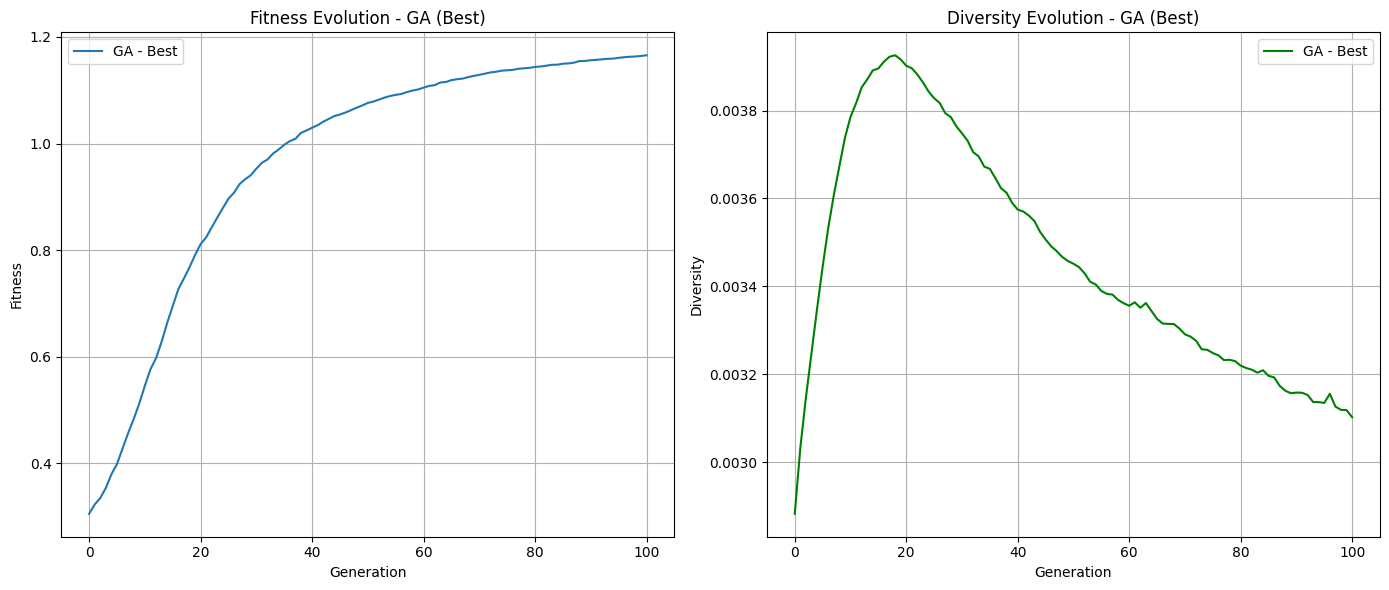

✅ Plotted fitness and diversity for GA - Best


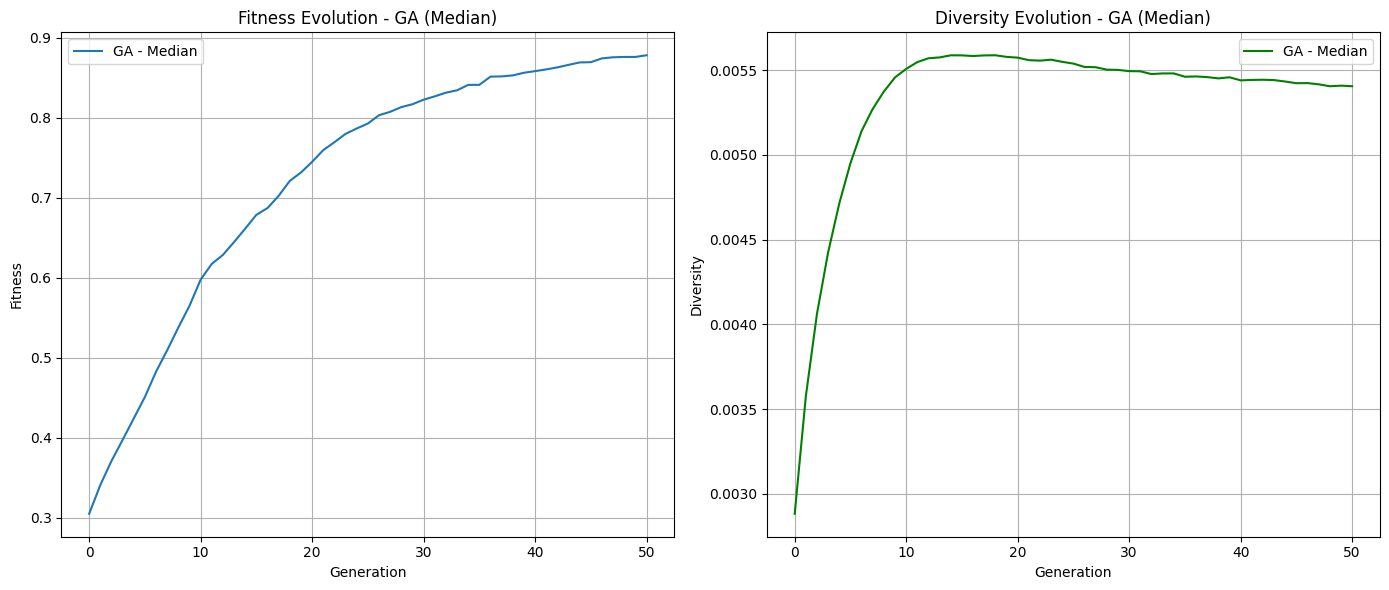

✅ Plotted fitness and diversity for GA - Median


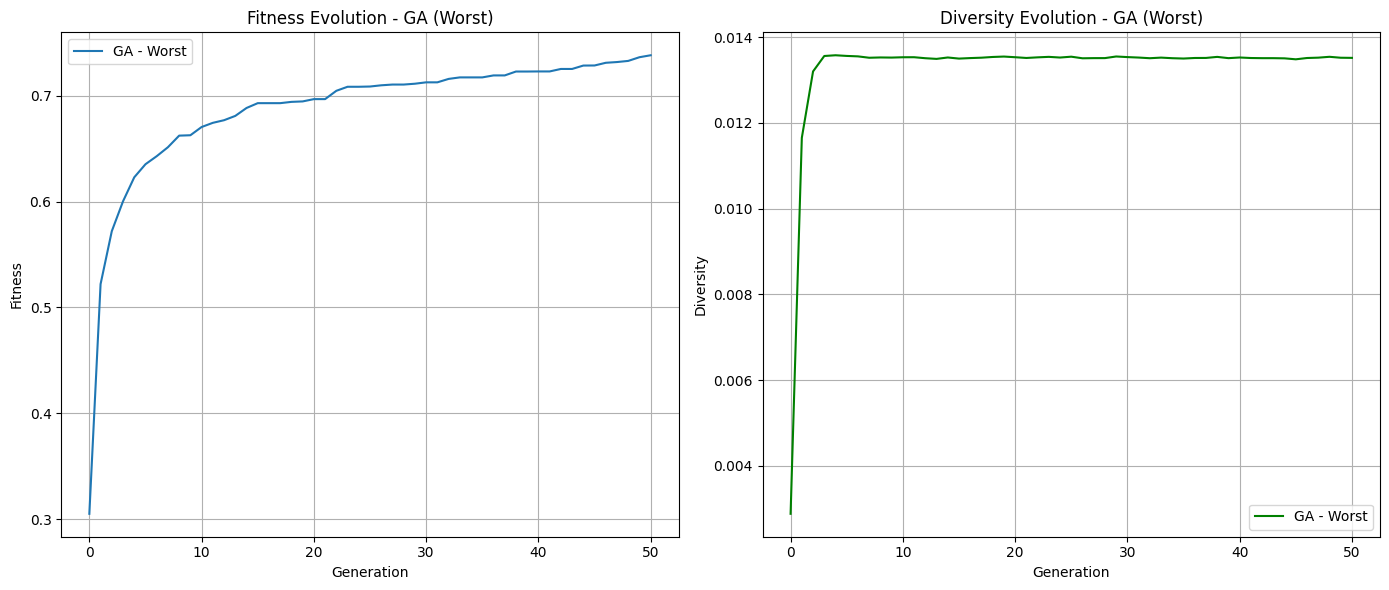

✅ Plotted fitness and diversity for GA - Worst


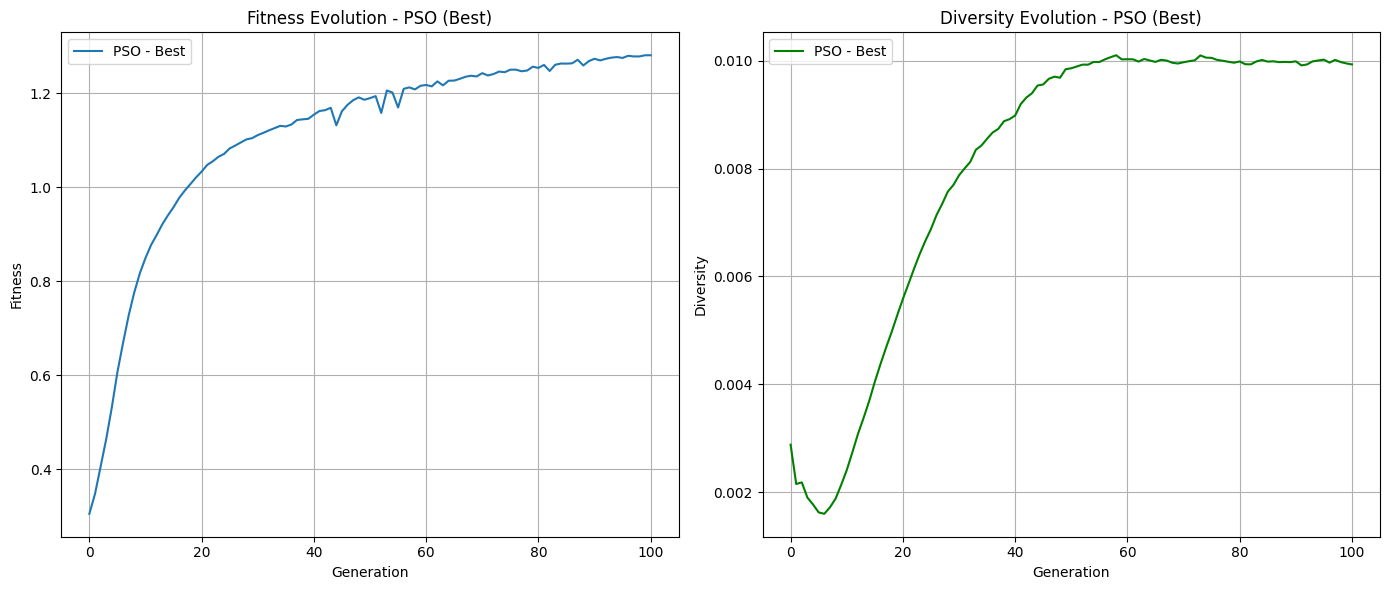

✅ Plotted fitness and diversity for PSO - Best


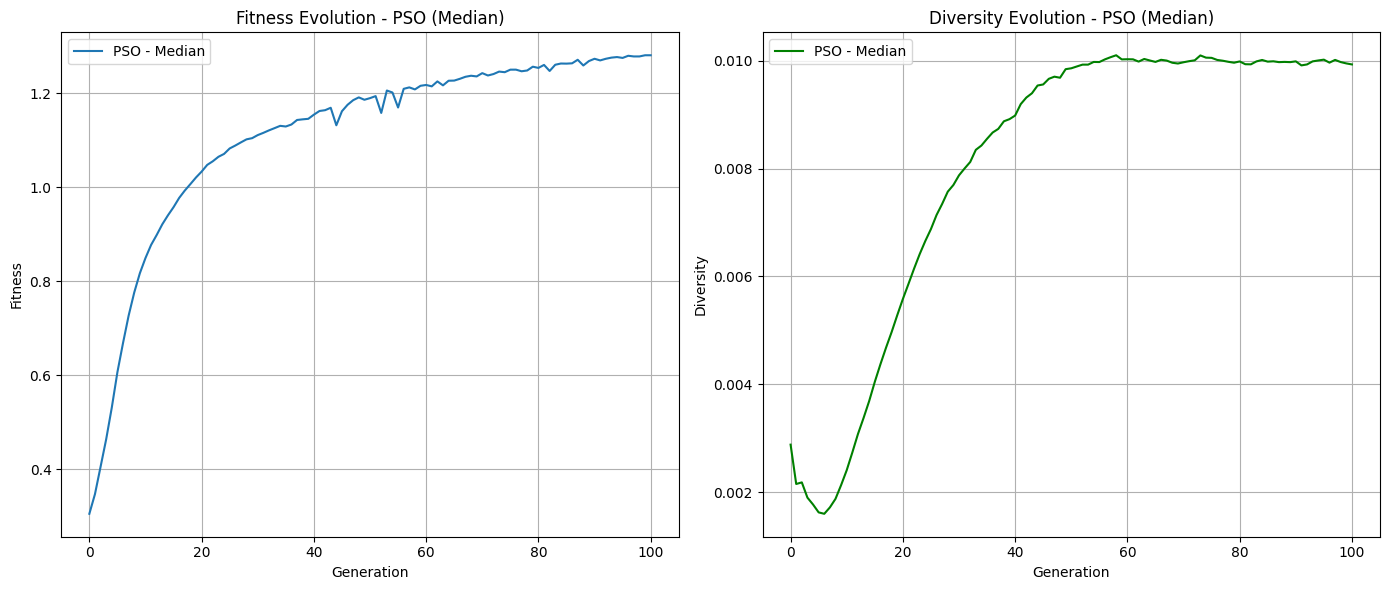

✅ Plotted fitness and diversity for PSO - Median


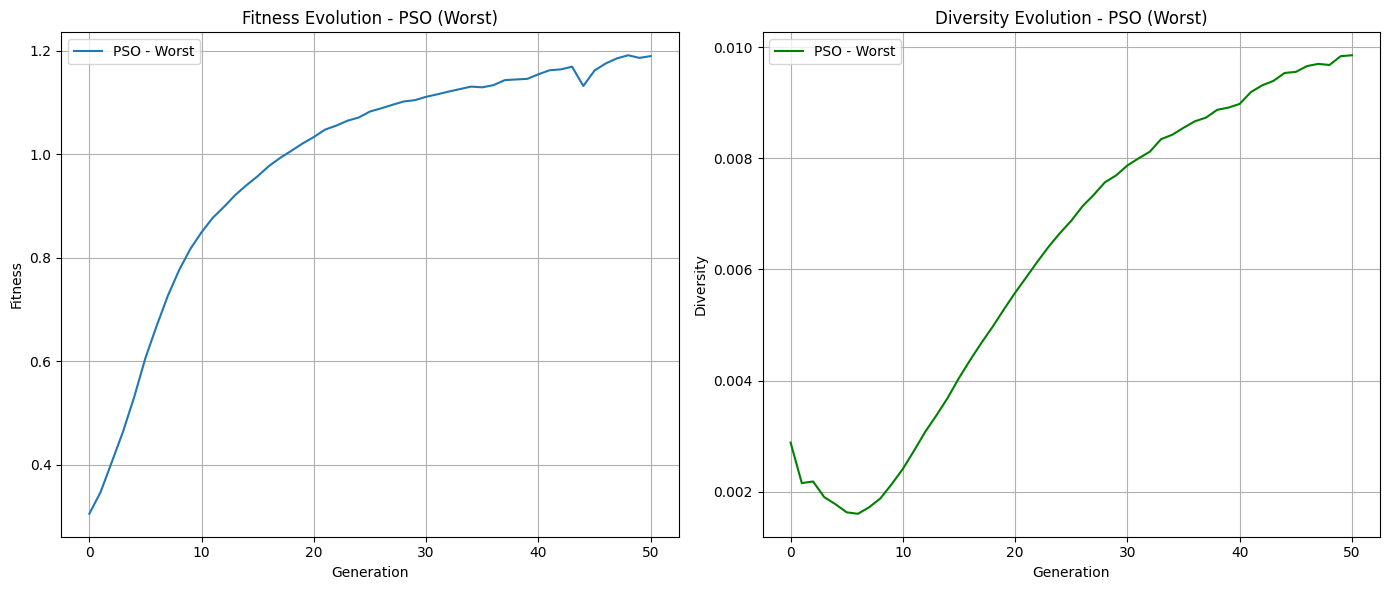

✅ Plotted fitness and diversity for PSO - Worst


In [16]:
# Plotting function for fitness and diversity
for algo in ["ga", "pso"]:
    for quality in ["best", "median", "worst"]:
        plot_fitness_diversity(
            final_results_df,
            get_results_path,
            generate_base_filename,
            algo,
            quality,
            correlation_level
        )

### Comparison of Best Fitness and Diversity between GA and PSO

- Compare the best fitness and diversity evolution between GA and PSO
- Helps in understanding which algorithm converges faster and maintains diversity

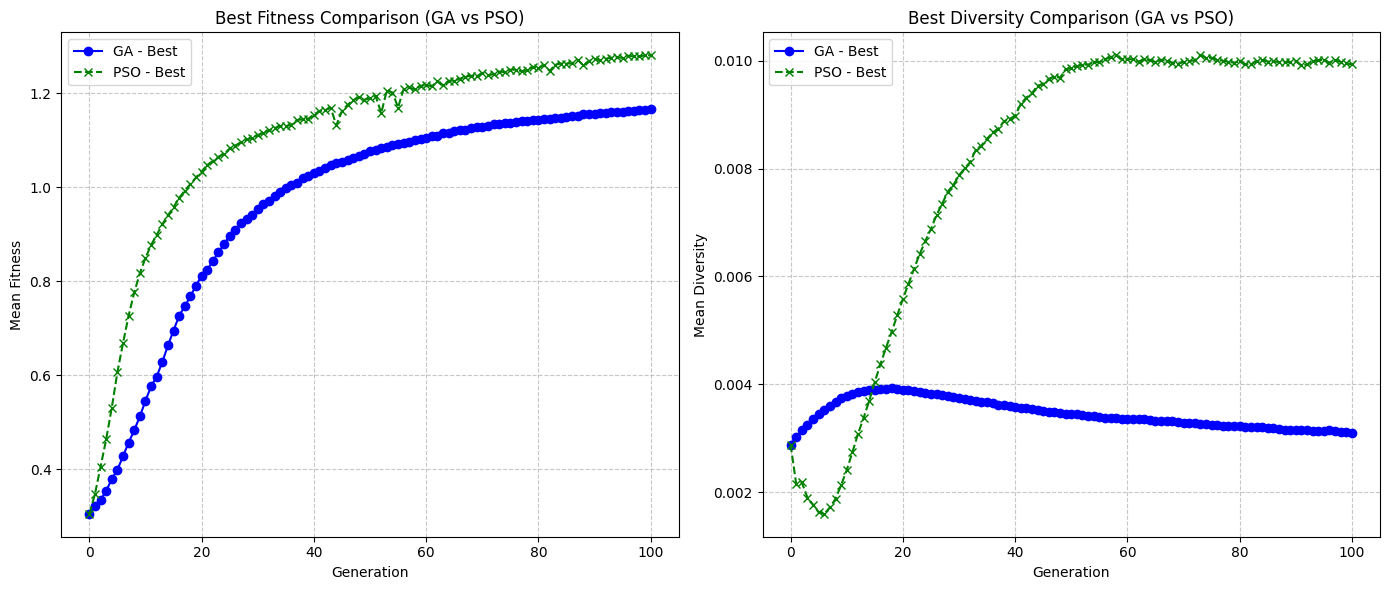

In [17]:
# Run the comparison function
compare_best_fitness_diversity(selected_configs, get_results_path, generate_base_filename)

### Final Fitness Distribution

- A box plot or violin plot showing the distribution of final fitness values for each algorithm
- Visualize the variability in performance

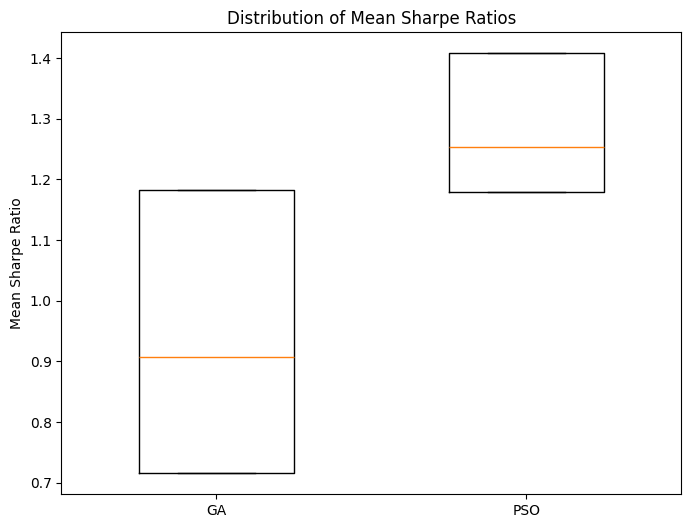

In [18]:
plot_fitness_distribution(final_results_df)

### Time taken per run

- A bar plot or box plot to show the time taken for each configuration
- Compare time taken between GA and PSO

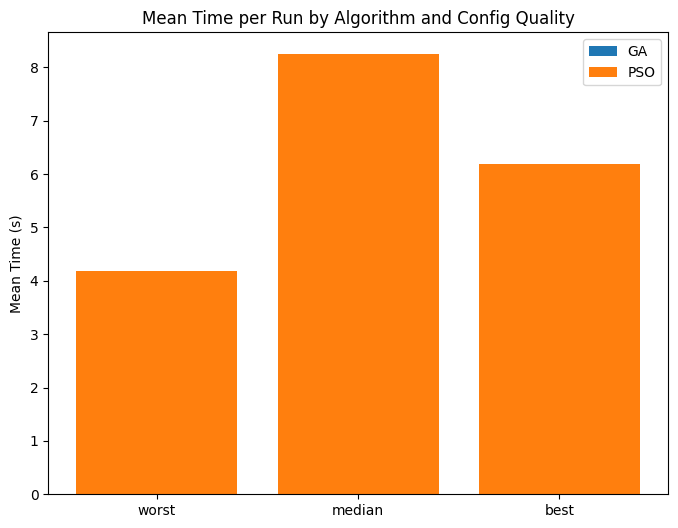

In [19]:
plot_time_per_run(final_results_df)

### Fitness vs. Time Tradeoff

- A scatter plot comparing the mean fitness vs. mean time taken
- Each point represents a different configuration

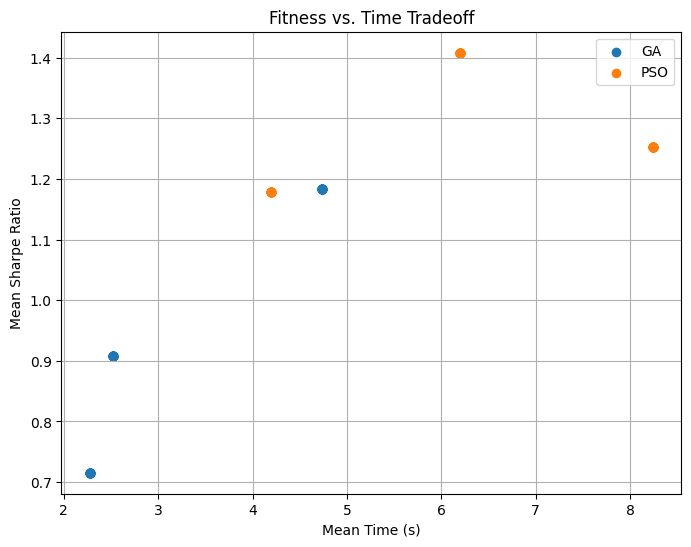

In [20]:
plot_fitness_vs_time(final_results_df)